## VSP Processing - from Separated Waves to Corridor Stack

This notebook works through the processing required to generate a corridor stack from the upgoing  
and downgoing p-waves of a zero-offset Vertical Seismic Profile (VSP).  

<img src="nb_images/procflow_decon.png" width="800" height="600" align="left" />  
<br clear="left"/>   
<br>
<br>  

The objective is to generate a zero-phase and multiple-free Corridor Stack trace. Looking ahead of the bit  
for reflections of an exploration target is a primary use of the corridor stack.

The corridor stack can be used to validate and calibrate the phase of surface seismic at the  
well location.  

Multiples on the surface seismic can be identified by their absence on the VSP corridor stack. 

<img src="nb_images/cstack1.png" width="600" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>  

The upgoing and downgoing waves were produced using the __VSP_processing_median_synthetic__ notebook. 

The raw data was generated using the __VSProwess__ Finite Difference modelling module.  
The model is elastic, anisotropic, and 2D. And fictional!

The notebook follows these basic steps:

1. Read processed upgoing and downgoing waves SEG-Y files
2. Frequency Analysis
3. Calculate velocities for plots  
4. Chose a trace range for deconvolution
5. Up by Down Deconvolution  
6. Corridor stack


### Imports and Packages  

Import the necessary packages to make the notebook run!

Your python installation should include numpy, scipy, matplotlib, Tabulate,  
and segyio. And Jupyter obviously!

After downloading my code from github repo (https://github.com/ajcampbell25/VSP_Basics), make sure the  
following folders exist in the path of the notebook:  
1. io_vsp  
2. proc_vsp  
3. plot_vsp  
4. nb_images
5. data

In [1]:
### The following 3 lines expand the useable area of the notebook
### Adjust percents to make bigger or smaller
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
display(HTML("<style>.output_result { max-width:75% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))

# important geophysical imports
# I use several methods to load packages  - as examples
from io_vsp import segyin
from io_vsp import segyout
from plot_vsp.seisplots import wiggle_plot, four_plots, composite_plot 
from plot_vsp.seisplots import plotcolor, decon_plots

# Best method is the one below, you always know where functions are 
# coming from
import proc_vsp.geometry as geom
import proc_vsp.spec as spec_1d  #specvsp
import proc_vsp.sigproc as sgp
import proc_vsp.utils as util_vsp
import proc_vsp.decon as dec


### 1. Load the VSP SEG-Y file  

 - uses segyio data loading package
 - source and receiver locations are assumed to be in SEG-Y trace headers
 - user needs to supply basic geometry parameters
      - __RepVel__ the seismic replacement velocity
      - __SRD_ASL__ the surface seismic datum elevation above sea level
      - __DF_ASL__ the drill floor elevation above sea level
      - __SrcElev__ the source elevation above sea level  

      
A 2D array of trace data is created, one row per trace.  A 2D array of the  
most important trace headers is created, one row per trace.

The number of samples, sample rate in microseconds and sample rate in hertz  
are written into Python variables.

<img src="nb_images/Geometry_a.png" width="400" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>  

$D_{source} = Elev_{SRD} – Elev_{source}$  

$D_{SRD} = (Elev_{SRD} – Elev_{KB}) + D_{KB}$  

<br>
<br>

In [2]:
######### get the downgoing and upgoing VSP SEG-Y data
    
filename1 = (r'C:\Users\hooge\GitHub\Geophysics\VSP_Basics\data\down_flat.sgy')
    
filename2 = (r'C:\Users\hooge\GitHub\Geophysics\VSP_Basics\data\residual_2wt.sgy')
        
# input desired geometry parameters
    
RepVel= 5000     # replacement velocity
SRD_ASL = 0    # SRD elevation above sea level
DF_ASL = 0    # drill floor elevation ASL
SrcElev = -10   # source elevation ASL

############ run basic loading functions ######### 

file_head = 'n'         # print binary and text header to screen    
pr_thead = 'n'          # print a table of trace headers    
down_flat, numsamp, samprate, fs, theader_decon =  segyin.readsegyio3(
                    filename1, file_head, 
                    DF_ASL, SrcElev, SRD_ASL, pr_thead)
    
up_flat, _, _, _, _ =  segyin.readsegyio3(
                    filename2, file_head, 
                    DF_ASL, SrcElev, SRD_ASL, pr_thead)


̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (270, 4800)  delta t : 1000.0
 data type : float32
 trace header file shape : (270, 15)
 samples : 4800  traces : 270  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  4800
 first time header value :  [142.79] 
 first lag time A value : [0] 
 first lag time B value : [142]
 source depth from header trace 1 : [10.]

̲D̲a̲t̲a̲ ̲L̲o̲a̲d̲i̲n̲g̲ ̲w̲i̲t̲h̲ ̲s̲e̲g̲y̲i̲o̲ ̲S̲t̲a̲t̲s̲ ̲:

 data shape : (270, 8270)  delta t : 1000.0
 data type : float32
 trace header file shape : (270, 15)
 samples : 8270  traces : 270  fs samprate hz :  1000.0 samprate microseconds :  1000 
 numsamp from headers :  8270
 first time header value :  [142.79] 
 first lag time A value : [0] 
 first lag time B value : [142]
 source depth from header trace 1 : [10.]


### 2. Frequency Analysis  
A Tukey window is applied to the input trace, prior to FFT  

The downgoing waves have the strongest amplitude and more representative amplitudes,  
due to their shorter travelpath.  

Use this spectrum to decide on a deconvolution operator frequency band.

In [3]:
###########  FRequency ANalysis 
    
trace = 120
time_win = 'y' # window trace prior to fft
time_range = [0, 2000]
freq_range = [0, 150]    
title_fran = 'Aligned downgoing'
# spec_1d(down_flat, time_range, freq_range, theader_decon, trace, fs, time_win, title_fran)    

### 3. Velocity Calculations for plots  
 - Not saved in segy file headers so need to be regenerated for plots
 - Calculate interval velocities. Shallowest velocity is calculated separately and tacked on to velocity array  
 - Generate a version which is rounded and truncated for display as text

In [4]:
############ geometry corrections and velocity calculations 
    
table = 'n'     # print a time-depth-velocity listing to screen y or n    
vel_headers = geom.geovel(theader_decon, RepVel, table)
    


̲G̲e̲o̲v̲e̲l̲ ̲S̲t̲a̲t̲s̲ ̲:
 Theader shape (270, 15) Vheader shape: (270, 17)
 TVD_SRD shape : (270,)  IntVel shape : (270,)
 TVDSrc 2 vals   [1040. 1090.] 
 TVDSRD 2 vals  [1050. 1100.] 
 TTVert 2 vals   [142.792 149.842]


### 4. Chose the desired trace range to process

In [5]:
############ trim arrays if requested
# rcv is receiver number
    
first_rcv =1
last_rcv = 300   
up_edit, thead_dec_edit = util_vsp.depthlimit(up_flat,vel_headers, 
                                            first_rcv, last_rcv)      
down_edit, _ = util_vsp.depthlimit(down_flat,vel_headers, 
                                            first_rcv, last_rcv)


̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (270, 8270)  data dtype :  float32
 headers shape : (270, 17)
 first : 0  last :  299
 headers new shape : (270, 17)
 data new shape :  (270, 8270)

̲D̲e̲p̲t̲h̲l̲i̲m̲i̲t̲ ̲S̲t̲a̲t̲s̲ ̲:
 data shape :  (270, 4800)  data dtype :  float32
 headers shape : (270, 17)
 first : 0  last :  299
 headers new shape : (270, 17)
 data new shape :  (270, 4800)


#### Make a wiggle plot of upgoing and downgoing waves 

pol :&emsp;&emsp;&emsp;&ensp;n for normal or tape polarity, r to flip polarity  
spacing :&emsp;&ensp;'z' is spread traces by receiver depth, anything else traces are evenly spaced  
skiplabel :&ensp;&ensp;plot every nth recever depth label at bottom of plot  
fs :&emsp;&emsp;&emsp;&ensp;&ensp;sample rate in hertz, may be set elsewhere in notebook    
norm :&emsp;&emsp;&ensp;plot trace normalization 'n' or 'y'  
scal :&emsp;&emsp;&ensp;&ensp;multiply every sample by this number to heat or cool plot  
info_wig :&emsp;print diagnostic information to terminal  
timframe:&emsp;'owt' is one-way time, 'twt' is two-way time, 'flat' is flattened  
&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;at an arbitrary time decided in the median filtering stage.

A scalar (__scal__) usually needs to be applied to make reasonable deflections,  
dependent on data amplitudes and plot spacing

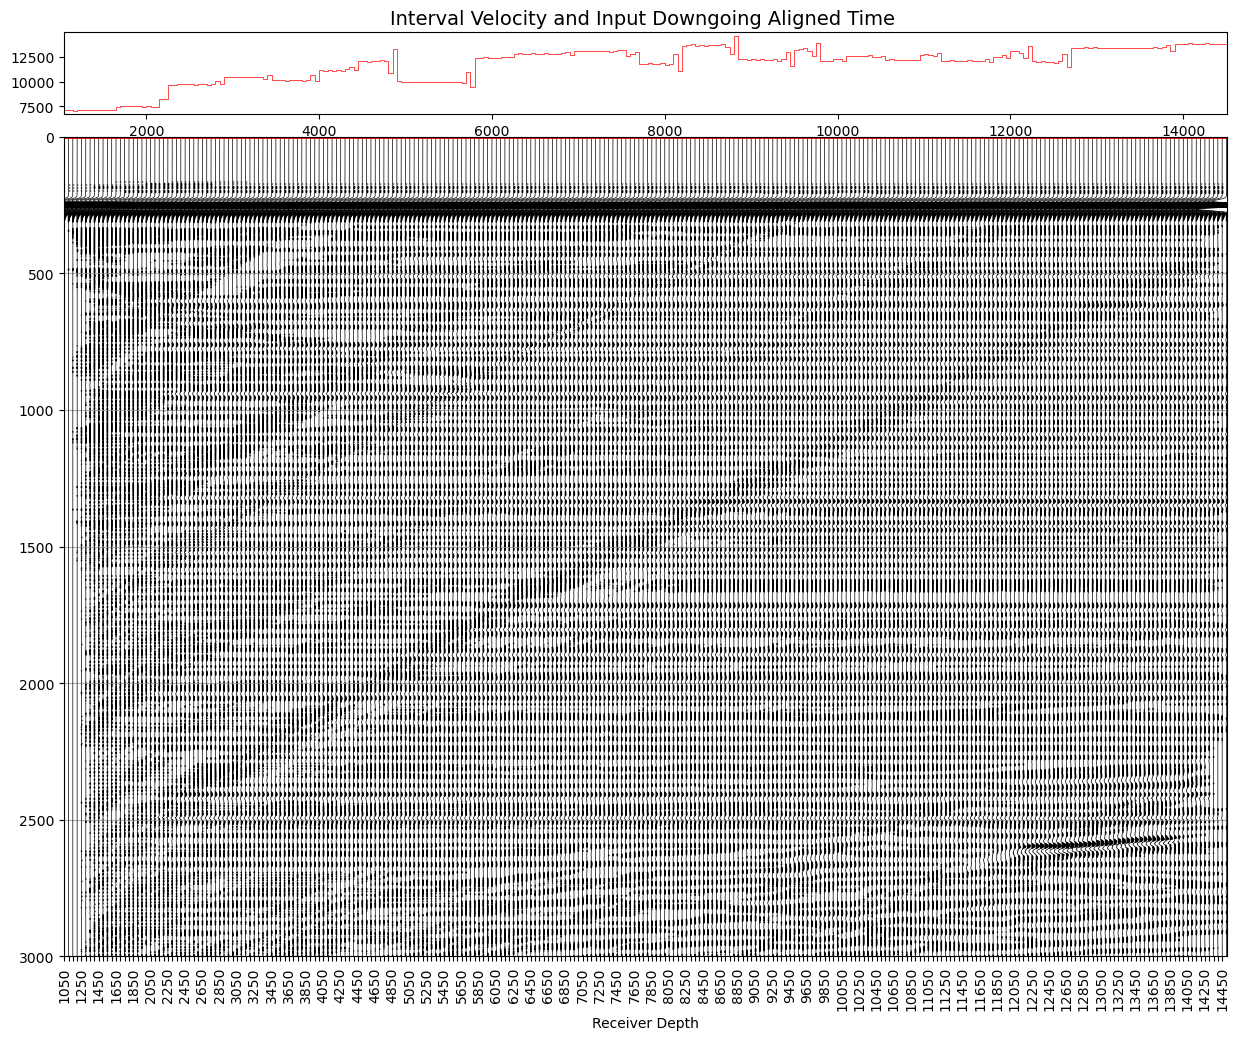


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 VSPdata.shape : (270, 4800)  (traces,samples)
 VSPdata type : float32
 Max an Min Amplitude VSPdata : 1.0 -0.74418294
 datascaled.shape  (270, 4800)  (traces,samples)
 thead shape : (270, 17)  (traces,header columns)
 Min TVDSRD - pad 1049.0  Pad : 1
 Max TVDSRD + pad 14501.0  Pad : 1
 min max intvel : 7082.152974504239 14577.25947521847


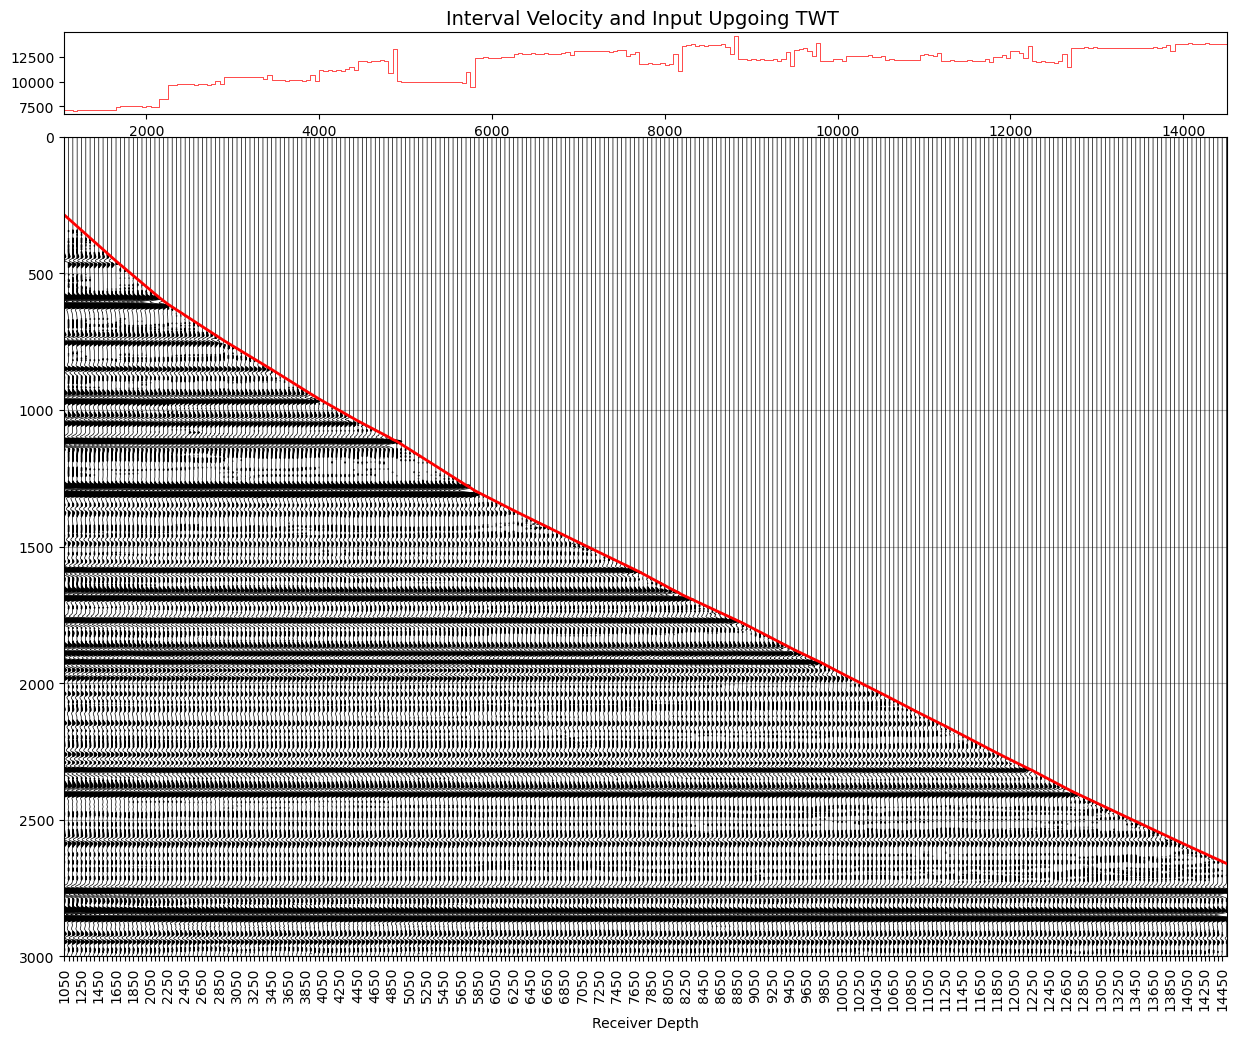


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 VSPdata.shape : (270, 8270)  (traces,samples)
 VSPdata type : float32
 Max an Min Amplitude VSPdata : 0.20959602 -0.24298312
 datascaled.shape  (270, 8270)  (traces,samples)
 thead shape : (270, 17)  (traces,header columns)
 Min TVDSRD - pad 1049.0  Pad : 1
 Max TVDSRD + pad 14501.0  Pad : 1
 min max intvel : 7082.152974504239 14577.25947521847


In [6]:
################## wiggle plot 

plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":500, 
                    "title_top":'Input Downgoing Aligned Time ',
                    "info_wig":'y',
                    "timframe":'flat'} 
wiggle_plot(thead_dec_edit,down_edit, **plot_params)    

plot_params = {"pol":'n', 
                    "Tmax":3000, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":'Input Upgoing TWT ',
                    "info_wig":'y',
                    "timframe":'twt'} 
wiggle_plot(thead_dec_edit,up_edit, **plot_params)

### 5. Up by Down (aka Waveshaping or VSP) Deconvolution  

Design deconvolution operators on **downgoing** waves  
 - desired output is a Butterworth wavelet
 - trace by trace filter design

Deconvolution operators are then applied to **upgoing** waves.  

A bandpass filter is applied to reduce noise which may be boosted by the deconvolution.

<img src="nb_images/decon_dwn2.png" width="400" height="300" align="left" />  
<br clear="left"/>   
<br>
<br>  

The design window should include the strong multiples.  
 - Multiples are delayed from the direct arrival and parallel to the direct arrival  
 
**This strategy is valid for near offset VSPs**  

__Near offset VSPs__ have similar reflected and multiple raypaths,  
with the same time delays for multiples.
 - Multiples have the same periodicity on the downgoing as on the upgoing  
  - Operators which remove multiples on the downgoing should remove the same multiples on the upgoing
 - Designing operators with long design windows on the downgoing and applying  
   the operators to the upgoing is reasonable

<img src="nb_images/multiples_near-far1.png" width="600" height="500" align="left" />  
<br clear="left"/>   
<br> 


__Longer offset VSPs__ have reflected and multiple raypaths which are significantly different  
 - decon may remove or alter reflections as well as multiples
 - a shorter design window just to zero-phase is reasonable  
 - predictive decon or another strategy may be necessary to reduce multiples  
 
__Deconvolution Parameters:__  

aligntime: The downgoing is aligned at this time, set in median filtering step  
wndw:&emsp;&ensp;&ensp;Window type applied to autocorrelation of downgoing waves  
&emsp;&emsp;&emsp;&ensp;&ensp;&ensp;1= do nothing - still working on this  
stab:&emsp;&ensp;&ensp;&ensp;Pre-whitening stabilization factor (decimal fraction)  
fs:&emsp;&emsp;&ensp;&ensp;&ensp;Sampling rate in hertz  
N:&emsp;&emsp;&emsp;&ensp;Number of autocorrelation lags (length of operator)  
backup:&emsp;Backup time before direct arrival (include full coda)  
winlngth:&ensp;Time widow starting at backup time for filter design  
lowcut:&ensp;&ensp;&ensp;Low frequency cutoff (Hz), post decon Butterworth filter  
highcut:&ensp;&ensp;High frequency cutoff (Hz), post decon Butterworth filter   
order:&emsp;&ensp;&ensp;Order of post decon Butterworth filter  
norm_wav:&ensp;Normalize to maximum amplitude of 1  
qc_plot:&ensp;&ensp;QC plots for a single test trace


̲W̲e̲i̲n̲e̲r̲_̲w̲a̲v̲e̲s̲h̲a̲p̲e̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs  : 1000.0 
 N : 1024 
 order : 2 
 aligntime : 250

Ricker Info
 duration : 1.024  dt : 0.001  f : 25


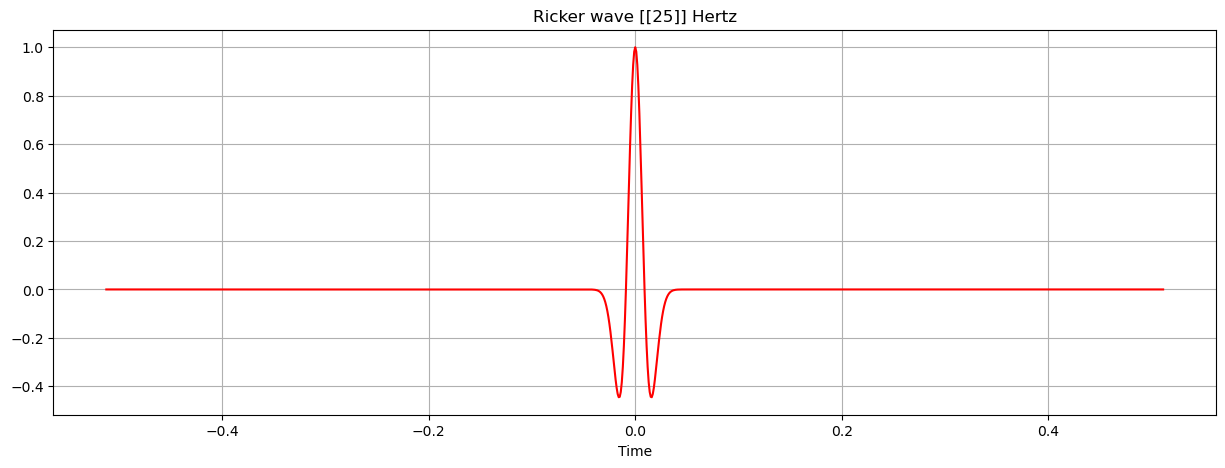


̲S̲h̲i̲f̲t̲i̲n̲g̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0 
  atime : 250 
  first arr2 shape : (1, 4800)

̲W̲a̲v̲e̲t̲r̲a̲c̲e̲ ̲P̲a̲r̲a̲m̲e̲t̲e̲r̲s̲ ̲:
 fs : 1000.0  numsamp : 1024
 plot_time shape : (4800,)
 wave shape : (1, 1024)  wavelets shape : (1, 4800)  wavelets_plot shape : (4800,)  waveshift shape : (1, 5050)  waveshift_plot shape : (4800,)


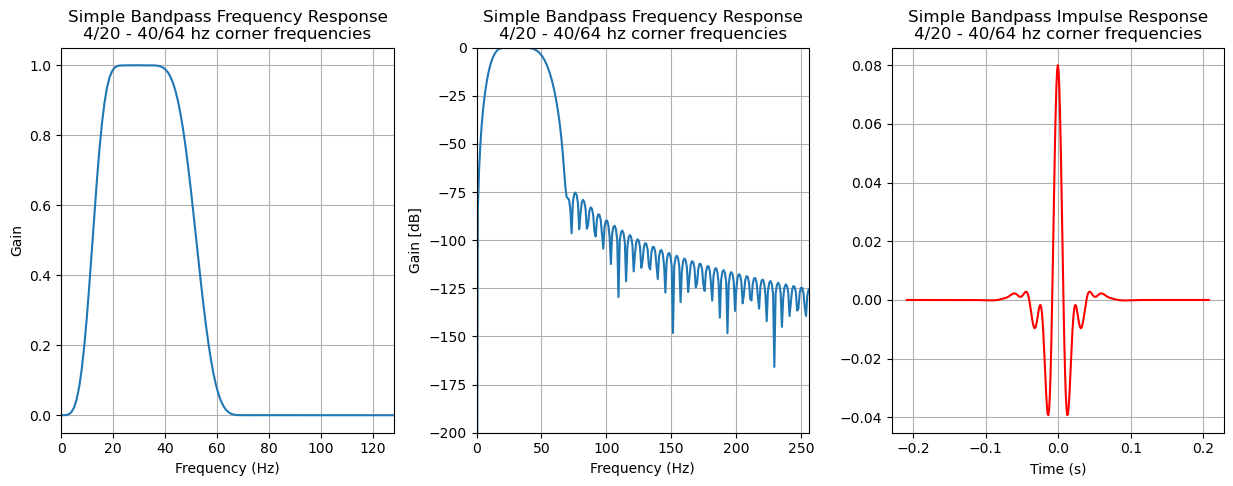

 np.argmax(cc_all[:,qc_trc]) : 2025


In [7]:
########### Waveshaping Decon - Weiner Filter 

wvdec_params = {'aligntime':250,
                    'wndw':1,
                    'stab':.20,
                    'fs':fs,
                    'N':1024,
                    'backup':200,  
                    'winlngth':2000,
                    'wavelet':'R',        # O for Ormsby, R for Ricker, B for Butterworth
                    'Rickf':25,           # Central frequency Ricker wavelet
                    'Ormsf':[2,12,40,64], # Corner freqs. for Ormsby wavelet
                    'BPF_type':'T',       # T for Trapezoidal, B for Butterworth
                    'Buttf':[18,55,2],    # highcut, low cut, order for Butterworth filter
                    'Trapf':[4,20,40,64], # Corner frequencies for Trapezoidal filter
                    'norm_wav':'y',
                    'qc_plot':'y', 'qc_trc':61, 'endplot':2100}

shaped_dwn,shaped_up = dec.Weiner_waveshape_decon(up_edit,down_edit, thead_dec_edit,**wvdec_params)

#### Make wiggle plots of deconvolved down and up waves 



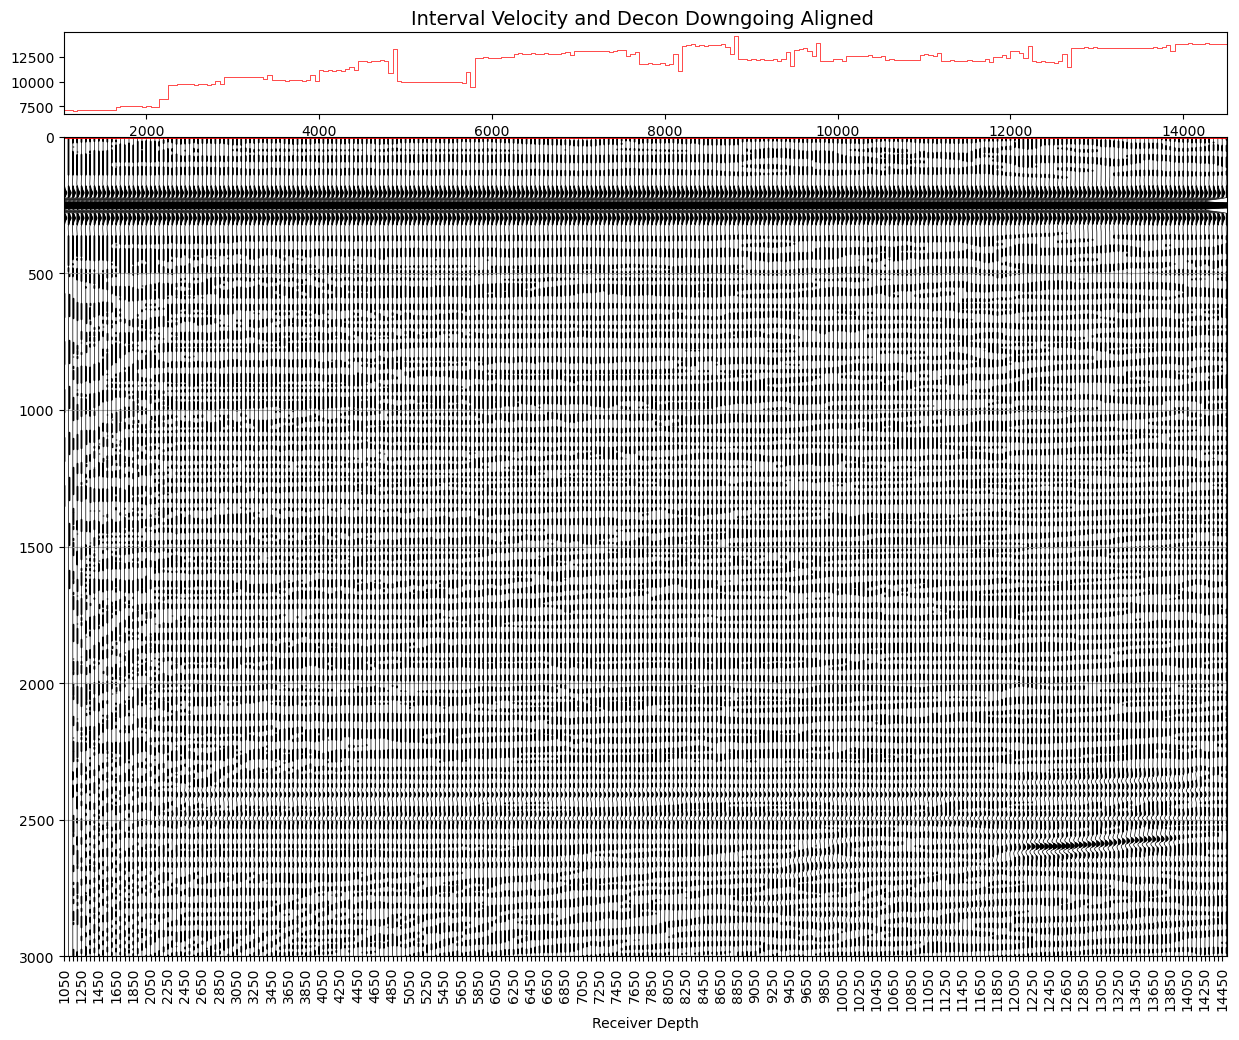

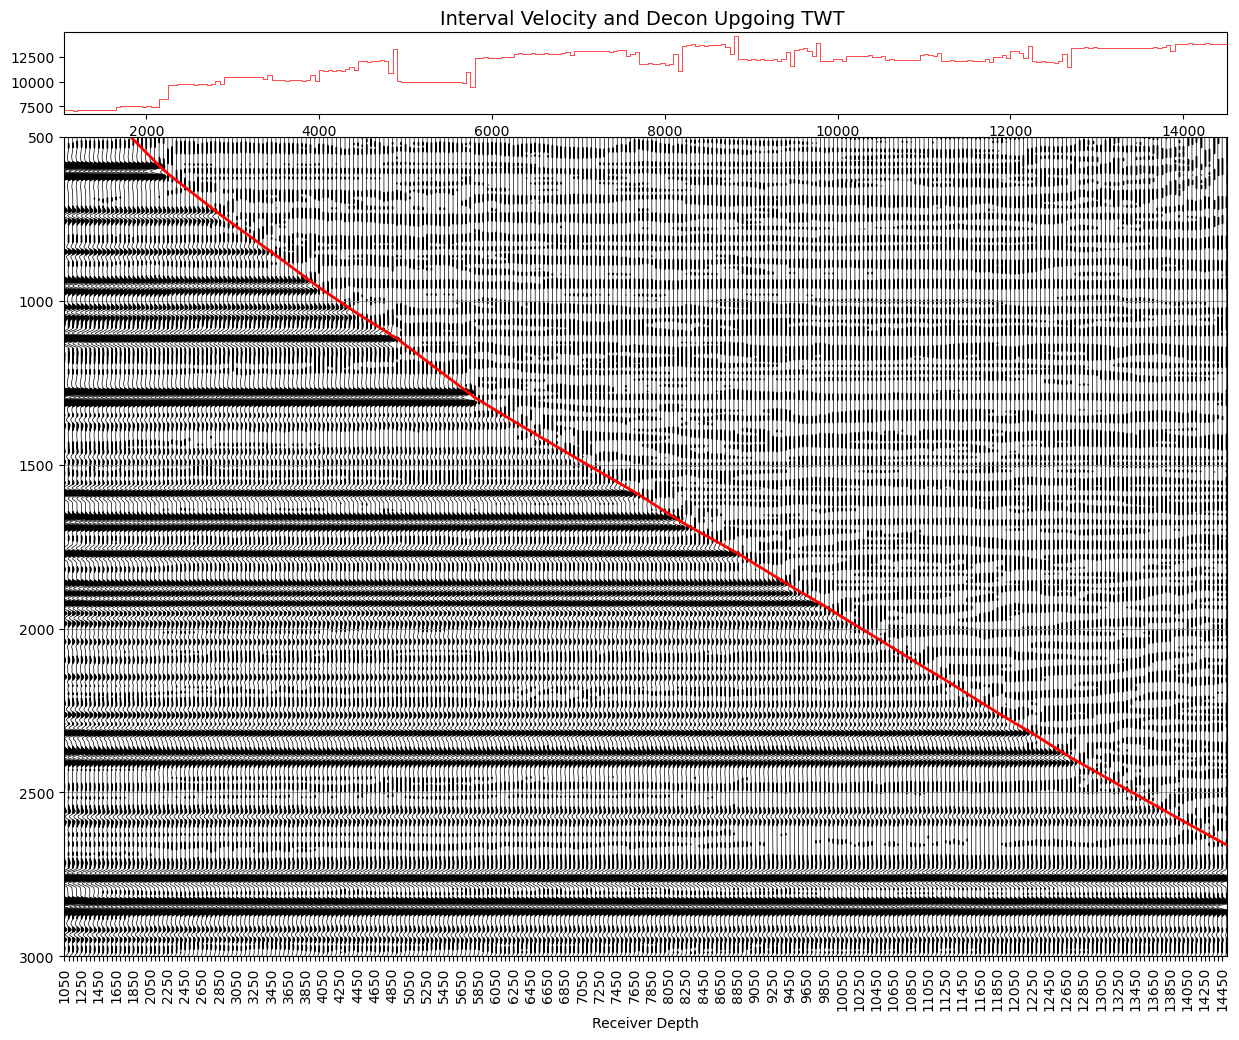

In [8]:
############ wiggle plots of downgoing, upgoing after decon

plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":0, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":500, 
                "title_top":'Decon Downgoing Aligned ',
                "info_wig":'n',
                "timframe":'flat'} 
wiggle_plot(thead_dec_edit,shaped_dwn, **plot_params)

plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":500, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":1000, 
                "title_top":'Decon Upgoing TWT ',
                "info_wig":'n',
                "timframe":'twt'} 
wiggle_plot(thead_dec_edit,shaped_up, **plot_params)


#### Apply a mute before break time to reduce noise  

Decon introduces some distracting noise prior to the direct arrival, just zero it out

In [9]:
# apply a mute before direct arrival time 
tframe = 'twt' # owt or twt    
mute_shaped_upwave2WT = util_vsp.mute(shaped_up,fs, thead_dec_edit, tframe)

#### Make wiggle plots of muted deconvolved up waves 



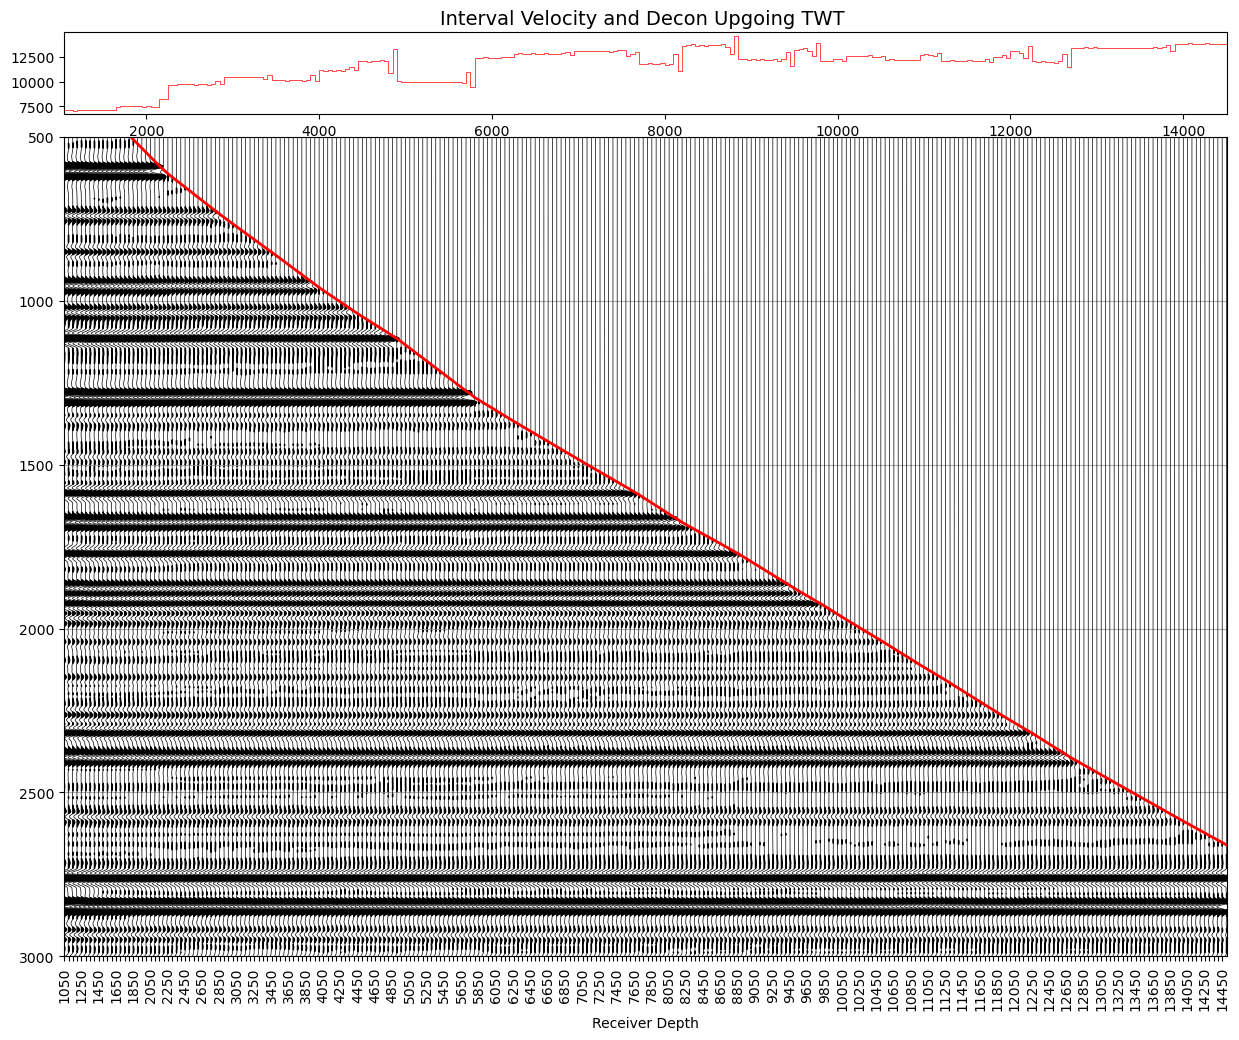

In [10]:
####### plot after muting before direct arrival
plot_params = {"pol":'n', 
                "Tmax":3000, "Tmin":500, 
                "first_rcv":first_rcv, 
                "spacing":'z', 
                "skiplabel":4, 
                "fs":fs, 
                "norm":'n',
                "scal":1000, 
                "title_top":'Decon Upgoing TWT ',
                "info_wig":'n',
                "timframe":'twt'} 
wiggle_plot(thead_dec_edit,mute_shaped_upwave2WT, **plot_params)
    

### 7. Generate a Corridor Stack  
Design a corridor near the downgoing arrivals which should contain only primaries  
 - mutliples are delayed from the primaries and do not reach the direct arrival  
   as the following model exercise shows:

<img src="nb_images/multiples3.png" width="700" height="500" align="left" />  
<br clear="left"/>   
<br>
<br>   
 
__Near surface multiples__ are usually attenuated by VSP deconvolution, as the multiple exists  
in the downgoing waves and the upgoing waves

__Internal (inter-bed)__ multiples are only partly attenuated as they have a short downgoing leg.  

The orange highlight indicates an internal multiple with a short corresponding downgoing leg. 

<img src="nb_images/multiples_internal1.png" width="900" height="600" align="left" />  
<br clear="left"/>   
<br>  

Only the orange segment will be attenuated with VSP deconvolution.

<img src="nb_images/multiples_internal3.png" width="450" height="300" align="left" />  
<br clear="left"/>   
<br>

Keep a few deep traces so that the corridor stack continues below td

<img src="nb_images/cstack1.png" width="600" height="400" align="left" />  
<br clear="left"/>   
<br>
<br>  

__Corridor Stack Parameters:__  

corrwin :&emsp;&ensp;Delay time from arrival time to apply a tail mute - avoid multiples  
keeptrcs :&emsp;Don't mute the bottom n traces  
repeat :&emsp;&ensp;&ensp;Corridor stack is a single trace. For a nice plot, repeat it n times



In [11]:
corrwin = 150 # mute delay after break time
keeptrcs = 15 # do not mute the bottom n traces
repeat = 8 # make n copies of stack trace
corr_in, corr_stk = sgp.cstack(mute_shaped_upwave2WT,thead_dec_edit,fs, corrwin, keeptrcs, repeat)

 np.nanmax(corrmute) : 0.11700759083032608  np.nanmax(corrstk) : 0.11415698379278183


#### Make L plot of corridor stack

pol :&emsp;&emsp;&emsp;&ensp;n for normal or tape polarity, r to flip polarity  
spacing :&emsp;&ensp;'z' is spread traces by receiver depth, anything else traces are evenly spaced  
skiplabel :&ensp;&ensp;plot every nth recever depth label at bottom of plot  
fs :&emsp;&emsp;&emsp;&ensp;&ensp;sample rate in hertz, may be set elsewhere in notebook    
norm :&emsp;&emsp;&ensp;plot trace normalization 'n' or 'y'  
scal :&emsp;&emsp;&ensp;&ensp;multiply every sample by this number to heat or cool plot  
info_wig :&emsp;print diagnostic information to terminal  
timframe:&emsp;for time header line - 'owt' is one-way time, 'twt' is two-way time, 'flat' is flattened  
&emsp;&emsp;&emsp;&emsp;&emsp;&ensp;at an arbitrary time decided in the median filtering stage.

A scalar (__scal__) usually needs to be applied to make reasonable deflections,  
dependent on data amplitudes and plot spacing

 pol : n  comp scalar : -10.714285714285715


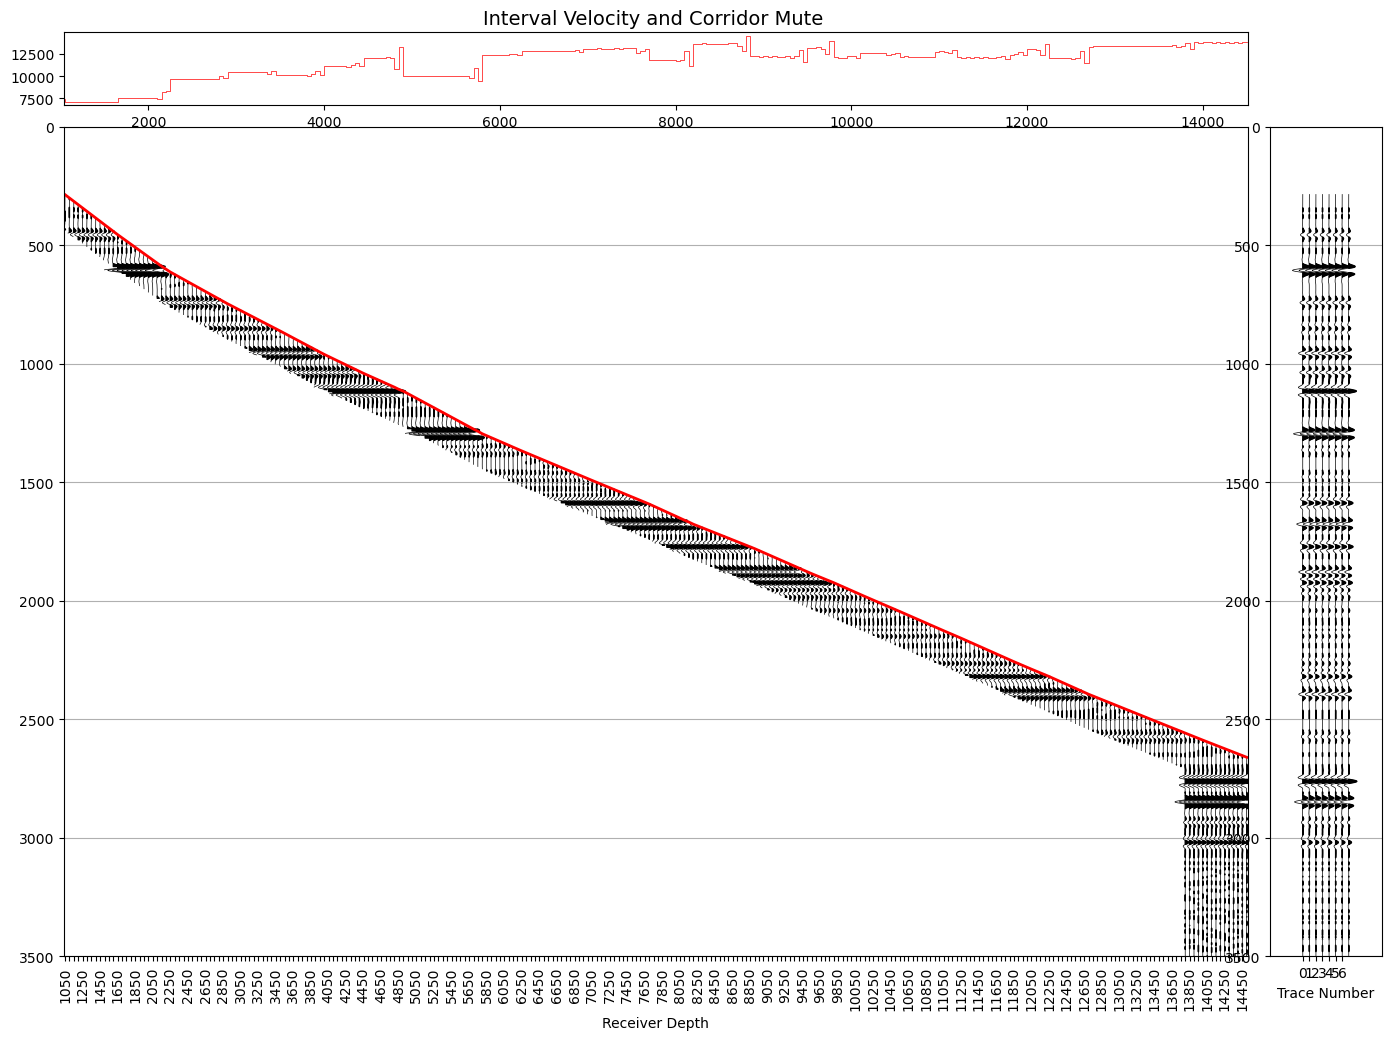


̲W̲i̲g̲g̲l̲e̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 VSPdata.shape : (270, 4800)  (traces,samples)
 VSPdata type : float64
 Max an Min Amplitude VSPdata : 0.11700759083032608 -0.16230687499046326
 Max an Min Amplitude Cstack : 0.11415698379278183 -0.146561861038208
 datascaled.shape  (270, 4800)  (traces,samples)
 thead shape : (270, 17)  (traces,header columns)
 Min TVDSRD - pad 1040.0  Pad : 10
 Max TVDSRD + pad 14510.0  Pad : 10
 min max intvel : 7082.152974504239 14577.25947521847


In [12]:
####### plot after muting before direct arrival
plot_params = {"pol":'n', 
                    "Tmax":3500, "Tmin":0, 
                    "first_rcv":first_rcv, 
                    "spacing":'z', 
                    "skiplabel":4, 
                    "fs":fs, 
                    "norm":'n',
                    "scal":1000, 
                    "title_top":'Corridor Mute ',
                    "info_wig":'y',
                    "timframe":'twt'} 
composite_plot(thead_dec_edit,corr_in,corr_stk, **plot_params)
    

## Alternate Processing Flow Plot  

A nice compact color display of all the pertinent steps.  

### Plotting Parameters  

ss_titlen :&emsp;&ensp;&ensp;Titles on top of each box  
savePNG :&ensp;&ensp;&ensp;Save a png file to the data subdirectory in the notebook path  
png_name :&ensp;&ensp;Too obvious to describe  
scal :&emsp;&emsp;&emsp;&ensp;&ensp;Multiply every sample by this number to heat or cool plot  
time_range :&ensp;&ensp;Plot start and end times  
depth_range : Plot start and end depths   
info_plot :&ensp;&ensp;&ensp;&ensp;Print diagnostic information to terminal

A scalar (__scal__) usually needs to be applied to make reasonable deflections,  
dependent on data amplitudes and plot spacing

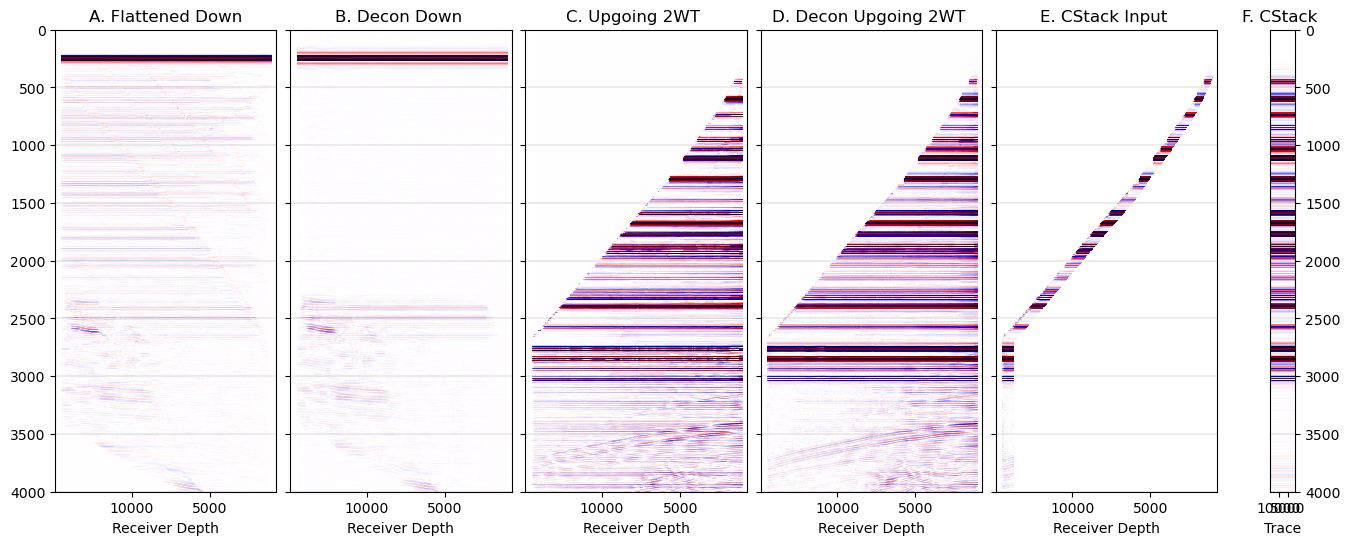


̲D̲e̲c̲o̲n̲ ̲P̲l̲o̲t̲ ̲G̲l̲o̲b̲a̲l̲ ̲I̲n̲f̲o̲r̲m̲a̲t̲i̲o̲n̲ ̲:
 Number of traces in plot : 270  Number of samples per trace :  tindex1 shape :, (4800,)  tindex1 min max : 0.0 4799.0
 Max an Min Amplitude Box 1. : 1.0 -0.74418294
 Max an Min Amplitude Box 2. : 0.8497226980777879 -0.5041610138493386
 Max an Min Amplitude Box 3. : 0.20959602 -0.24298312
 Max an Min Amplitude Box 4. : 0.1887883 -0.2137161
 Max an Min Amplitude Box 5. : 0.11700759083032608 -0.16230687499046326
 Max an Min Amplitude Box 6. : 0.11415698379278183 -0.146561861038208


In [13]:
########## make thumbnail processing plots 

deconplot_params = {   
    'ss_title1' : "A. Flattened Down",    
    'ss_title2' : "B. Decon Down",    
    'ss_title3' : "C. Upgoing 2WT",    
    'ss_title4' : "D. Decon Upgoing 2WT",
    'ss_title5' : "E. CStack Input",
    'ss_title6' : "F. CStack",

    'savePNG' : 'y',        
    'png_name' : 'post_decon',    
    'scal' : [4,4,4,4,4,4],            # scaling to plot 1,2,3,4,5,6 amplitudes    
    'time_range' : [0, 4000],    
    'depth_range' : [14900, 750],
    'info_plot' : 'y'}
decon_plots(down_flat,shaped_dwn, up_flat,mute_shaped_upwave2WT , corr_in, corr_stk, fs, 
               thead_dec_edit, **deconplot_params)
#five_plots(residual, upwave1WT, upwave2WT, mute_medianup2WT, fs, 
#               theader_edit, **plot4_params)    